Display the game state graph, showing vertices taken by each player and the edge vertices

In [2]:
import sys, os; sys.path.insert(1, os.path.join(sys.path[0], '..'))
import torch
import pandas as pd
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt

import games.hex.vortex_board as vb

In [3]:
def show_board(board, edge_index=None, node_labels=False, line_style='g-'):
    node_pos = board.node_attr[:, -2:]

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_aspect('equal')
    ax.get_figure().set_size_inches(10, 10)

    # plot the edges
    if edge_index is None:
        edge_index = board.edge_index
    for edge in edge_index.T:
        edge_line = node_pos[edge].T
        ax.plot(edge_line[0], edge_line[1], line_style)

    # plot the nodes
    ax.scatter(node_pos[-4:, 0], node_pos[-4:, 1], s=400, c='w')
    colours = np.full_like(board.node_attr[:, 0], 'w', dtype=np.str0)
    colours[board.node_attr[:, vb.HORIZONTAL_PLAYER] == 1.] = 'r'
    colours[board.node_attr[:, vb.VERTICAL_PLAYER] == 1.] = 'b'
    sizes = np.full_like(board.node_attr[:, 0], 50)
    sizes[board.node_attr[:, vb.HORIZONTAL_PLAYER] == 1.] = 250
    sizes[board.node_attr[:, vb.VERTICAL_PLAYER] == 1.] = 250
    ax.scatter(node_pos[:, 0], node_pos[:, 1], s=sizes, c=colours)
    if node_labels:
        for i, pos in enumerate(node_pos):
            ax.annotate(str(i), pos, )
            
    plt.show()

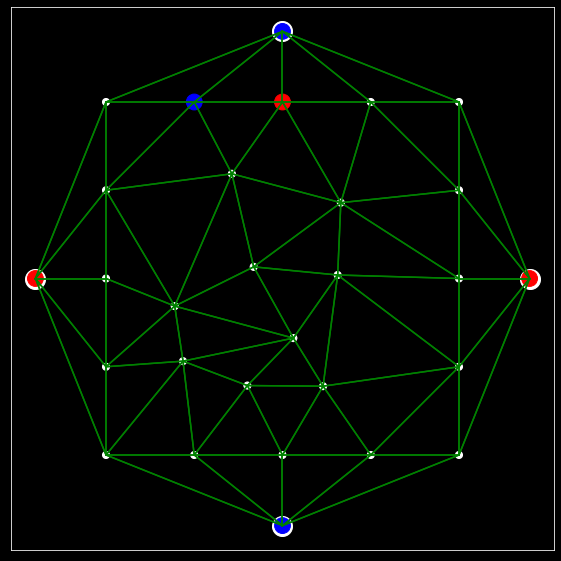

In [7]:
board = vb.VortexBoard.new_vortex_board(size=5)
cells = np.arange(board.node_count-4)
np.random.shuffle(cells)
for n in range(2):
    board.set_stone(cells[n], n%2)
    
show_board(board)

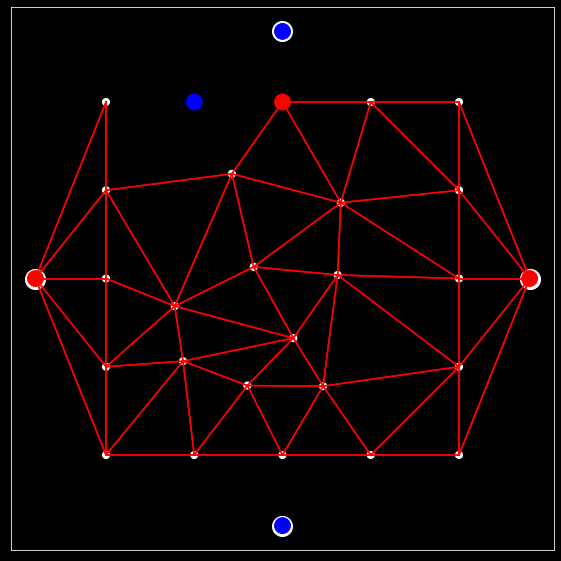

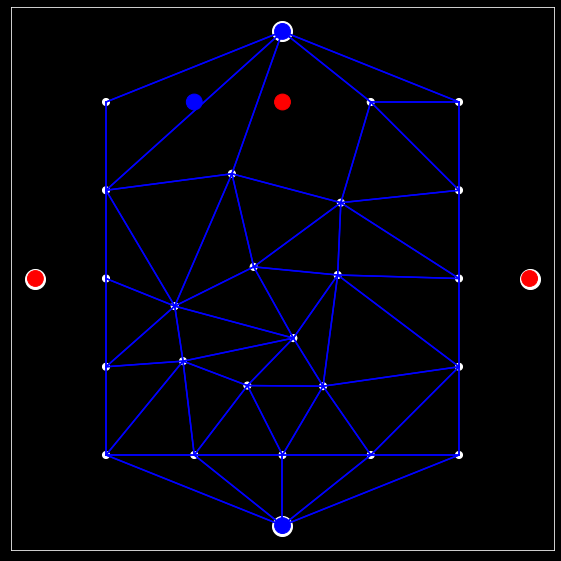

In [8]:
_, edge_index = board.get_vor_attr(vb.HORIZONTAL_PLAYER)
show_board(board, edge_index, line_style='r-')
_, edge_index = board.get_vor_attr(vb.VERTICAL_PLAYER)
show_board(board, edge_index, line_style='b-')